In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import re
from tqdm import tqdm
import time


# Load the .env file
load_dotenv()

df = pd.read_csv('Data/bbc_news_reasons.csv')

In [2]:
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...
...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...


In [3]:
# Drop all rows that contain any missing values
df = df.dropna()
df.reset_index

# Check the DataFrame after dropping rows with missing values
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...
...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...


In [4]:
df.value_counts('original_code')

original_code
politics         25
sport            25
business         20
entertainment    17
tech             11
Name: count, dtype: int64

In [5]:
df.value_counts('replicated_code')


replicated_code
politics         30
sport            24
business         17
entertainment    17
tech             10
Name: count, dtype: int64

In [6]:
df.value_counts('model_code')

model_code
politics         34
sport            23
business         18
entertainment    14
tech              9
Name: count, dtype: int64

/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/3886461982.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - width, original_code_counts[i] + 0.5, str(original_code_counts[i]), ha='center')
/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/3886461982.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i], replicated_code_counts[i] + 0.5, str(replicated_code_counts[i]), ha='center')
/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/3886461982.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

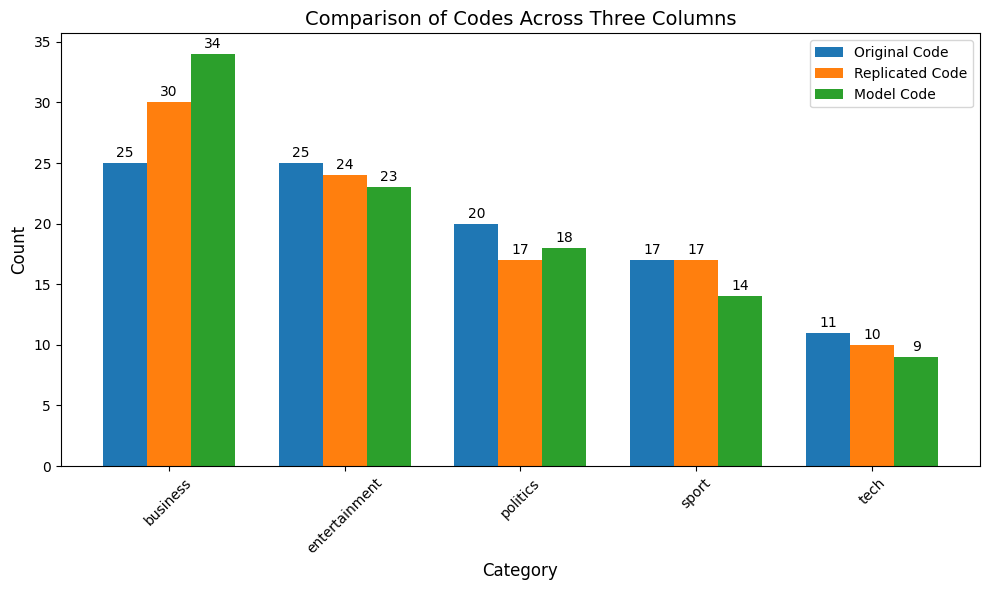

In [5]:
# Categories for the x-axis (you can extract this from your df)
categories = sorted(set(df['original_code']) | set(df['replicated_code']) | set(df['model_code']))

# Get value counts for each column, reindex to align with all categories
original_code_counts = df['original_code'].value_counts()
replicated_code_counts = df['replicated_code'].value_counts()
model_code_counts = df['model_code'].value_counts()

# Number of categories
n = len(categories)

# Create a range for the x-axis based on the number of categories
x = np.arange(n)

# Set the width of the bars
width = 0.25

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, original_code_counts, width, label='Original Code')
plt.bar(x, replicated_code_counts, width, label='Replicated Code')
plt.bar(x + width, model_code_counts, width, label='Model Code')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Comparison of Codes Across Three Columns', fontsize=14)
plt.xticks(x, categories, rotation=45)

# Loop through each bar and add the value labels
for i in range(n):
    plt.text(x[i] - width, original_code_counts[i] + 0.5, str(original_code_counts[i]), ha='center')
    plt.text(x[i], replicated_code_counts[i] + 0.5, str(replicated_code_counts[i]), ha='center')
    plt.text(x[i] + width, model_code_counts[i] + 0.5, str(model_code_counts[i]), ha='center')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### BBC News Codebook

| Code Name    | Original Code Description                       | Revised Code Description                           |
|--------------|--------------------------------------------------|----------------------------------------------------|
| business     | Is this news story about business?               | Is this news story about business?                 |
| entertainment| Is this news story about entertainment?          | Is this news story about entertainment?            |
| politics     | Is this news story about politics?               | Is this news story about politics?                 |
| sport        | Is this news story about sports?                 | Is this news story about sports?                   |
| tech         | Is this news story about tech?                   | Is this news story about tech?                     |


### Column Explanations
- **text_id**: Unique ID for each text document
- **code_id**: Unique ID for each code category
- **text**: Document text that's been coded
- **original_code**: Coded response from the original datasets
- **replicated_code**: Coded response from independent coding exercise from our study team
- **model_code**: Coded response generated from the LLM (GPT-3.5-turbo)
- **reason**: LLM generated reason for coding decision


In [29]:
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ..."
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...
...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...


In [21]:
# Load environment variables
load_dotenv()

# Together API endpoint and key
endpoint = 'https://api.together.xyz/inference'
TOGETHER_API_KEY = os.getenv('TOGETHER_API_KEY')

# Example codebook you can customize
CODEBOOK = """
business: Tweets or news articles related to companies, financial markets, economic issues, or industry trends.
entertainment: Tweets or news articles related to movies, music, celebrities, cultural events, or leisure activities.
politics: Tweets or news articles related to government, elections, political parties, policies, or international relations.
sport: Tweets or news articles related to sporting events, athletes, competitions, or athletic activities.
tech: Tweets or news articles related to technology advancements, innovation, science, or tech companies.
"""

def prepare_prompt(text):
    system_prompt = f"""
    You are a qualitative coder who is annotating BBC news stories.
    Your task is to assign ONE code from the codebook and explain your reasoning.
    
    YOU MUST INCLUDE BOTH A CODE AND A REASON IN YOUR RESPONSE.
    
    REQUIRED FORMAT:
    Code: [single word category]
    Reason: [at least one sentence explaining why you chose this code]
    
    Codebook:
    ---
    {CODEBOOK}
    ---
    Text:
    ---
    {text}
    ---
    """
    return system_prompt


def classify_text(text, retry_count=3, retry_delay=1):
    """Classify text with retry logic and rate limiting."""
    for attempt in range(retry_count):
        try:
            headers = {
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
                "Content-Type": "application/json"
            }
            
            data = {
                "model": "meta-llama/Llama-3-70b-chat-hf",
                "prompt": prepare_prompt(text),
                "max_tokens": 500,
                "temperature": 0.7,
                "top_p": 0.9,
                "top_k": 40,
                "repetition_penalty": 1,
                "min_tokens": 20
            }
            
            response = requests.post(endpoint, json=data, headers=headers)
            response.raise_for_status()
            
            response_data = response.json()
            
            if 'output' in response_data and isinstance(response_data['output'], dict):
                output = response_data['output'].get('choices', [{}])[0].get('text', '')
            else:
                output = response_data.get('output', {}).get('text', '')
            
            if not output:
                raise ValueError("Empty response from API")
            
            print("\nRaw model output:", output)  # Debug output
                
            # Extract code and reasoning using patterns
            code_patterns = [
                r'Code:\s*([a-zA-Z]+)(?=\s*Reason:)',  # Primary pattern: Code: followed by Reason:
                r'Code:\s*([a-zA-Z]+)',  # Backup pattern: just Code: and category
                r'\b(sport|business|politics|entertainment|tech)\b'  # Last resort pattern
            ]
            
            code = "Unknown"
            print("\nTrying code patterns:")  # Debug output
            for pattern in code_patterns:
                match = re.search(pattern, output, re.IGNORECASE)
                print(f"Pattern '{pattern}': {'Match found' if match else 'No match'}")  # Debug output
                if match:
                    code = match.group(1).lower().strip()
                    print(f"Found code: {code}")  # Debug output
                    break
            
            reasoning_patterns = [
                r'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))',  # Everything between Reason: and Code: or end
                r'Reason:\s*([\s\S]+)$'  # Backup: everything after Reason: to end
            ]
            
            reasoning = "No reasoning provided"
            print("\nTrying reasoning patterns:")  # Debug output
            for pattern in reasoning_patterns:
                match = re.search(pattern, output, re.IGNORECASE)
                print(f"Pattern '{pattern}': {'Match found' if match else 'No match'}")  # Debug output
                if match:
                    reasoning = match.group(1).strip()
                    print(f"Found reasoning: {reasoning[:100]}...")  # Debug output
                    break
            
            if reasoning == "No reasoning provided" and output:
                reasoning = output.strip()
                print("Using raw output as reasoning")  # Debug output
            
            # Force code to 'business' if text contains specific economic keywords
            economic_keywords = ['economy', 'recession', 'economic', 'gdp', 'market']
            if code == "Unknown" and any(keyword in text.lower() for keyword in economic_keywords):
                code = "business"
                print(f"Forced code to 'business' due to economic keywords")  # Debug output
            
            return code, reasoning
                
        except (requests.exceptions.RequestException, ValueError) as e:
            if attempt == retry_count - 1:  # Last attempt
                return "Error", f"API request failed after {retry_count} attempts: {str(e)}"
            time.sleep(retry_delay * (attempt + 1))  # Exponential backoff
            continue
            
        except Exception as e:
            return "Error", f"Processing failed: {str(e)}"

def process_dataframe(df, batch_size=100, save_interval=500):
    """
    Process the entire dataframe with progress tracking and periodic saving.
    
    Args:
        df (pd.DataFrame): Input dataframe to process
        batch_size (int): Number of rows to process before updating progress
        save_interval (int): Number of rows to process before saving intermediate results
        
    Returns:
        pd.DataFrame: Processed dataframe with predictions and reasoning
    """
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Initialize columns for results if they don't exist
    if 'model_prediction' not in df_processed.columns:
        df_processed['model_prediction'] = None
    if 'reasoning' not in df_processed.columns:
        df_processed['reasoning'] = None
    
    # Get indices of unprocessed rows
    unprocessed_mask = df_processed['model_prediction'].isna()
    total_unprocessed = unprocessed_mask.sum()
    
    if total_unprocessed == 0:
        print("All rows have already been processed!")
        return df_processed
    
    print(f"Processing {total_unprocessed} unprocessed rows...")
    
    # Create progress bar
    with tqdm(total=total_unprocessed) as pbar:
        processed_count = 0
        
        # Process rows in batches
        for idx in df_processed[unprocessed_mask].index:
            try:
                text = df_processed.loc[idx, 'text']
                code, reasoning = classify_text(text)
                
                df_processed.loc[idx, 'model_prediction'] = code
                df_processed.loc[idx, 'reasoning'] = reasoning
                
                processed_count += 1
                pbar.update(1)
                
                # Save intermediate results
                if processed_count % save_interval == 0:
                    print(f"\nSaving intermediate results after processing {processed_count} rows...")
                    df_processed.to_csv('intermediate_results.csv', index=False)
                    
                # Add a small delay every batch_size rows to avoid rate limiting
                if processed_count % batch_size == 0:
                    time.sleep(1)
                    
            except Exception as e:
                print(f"\nError processing row {idx}: {str(e)}")
                continue
    
    # # Save final results
    # print("\nSaving final results...")
    # df_processed.to_csv('llama3_bbc.csv', index=False)
    
    # Print summary
    success_count = df_processed['model_prediction'].notna().sum() - df_processed['model_prediction'].eq('Error').sum()
    error_count = df_processed['model_prediction'].eq('Error').sum()
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {success_count} rows")
    print(f"Errors: {error_count} rows")
    
    return df_processed

# Example usage:
df_results = process_dataframe(df)

Processing 98 unprocessed rows...


  1%|          | 1/98 [00:02<03:28,  2.15s/it]


Raw model output:  Code: sport
     Reason: The article is about Mike Tindall, an English rugby player, and his contract negotiations with Bath Rugby Club, which falls under the category of sports news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about Mike Tindall, an English rugby player, and his contract negotiations with Bath ...


  2%|▏         | 2/98 [00:03<02:51,  1.79s/it]


Raw model output:  Code: sport
     Reason: The article is primarily about a tennis tournament, specifically the SAP Open, and reports on the progress of various players, including Andy Roddick and Andre Agassi, in the competition.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is primarily about a tennis tournament, specifically the SAP Open, and reports on the pr...


  3%|▎         | 3/98 [00:04<02:12,  1.39s/it]


Raw model output:  Code: business
    Reason: This news story is about a Chinese dam firm defying Beijing's order to stop construction of one of its giant dams due to environmental concerns, which relates to business and economic issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news story is about a Chinese dam firm defying Beijing's order to stop construction of one of i...


  4%|▍         | 4/98 [00:05<02:01,  1.29s/it]


Raw model output:  Code: sport
     Reason: The article is discussing a football player, Adrian Mutu, and his situation with his club, Chelsea, due to a drug ban, which is a sports-related topic.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is discussing a football player, Adrian Mutu, and his situation with his club, Chelsea, ...


  5%|▌         | 5/98 [00:07<02:01,  1.31s/it]


Raw model output:  Code: sport
    Reason: I chose the code "sport" because the article is about Steven Gerrard, a football player, and his desire to stay at Liverpool FC and win trophies with the club. The article also mentions other sports-related topics, such as the Champions League, transfer windows, and the signing of other players like Fernando Morientes.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "sport" because the article is about Steven Gerrard, a football player, and his des...


  6%|▌         | 6/98 [00:08<01:49,  1.19s/it]


Raw model output:  Code: sport
     Reason: The article is discussing athletic competitions and achievements, specifically indoor track and field events, which falls under the category of sport.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is discussing athletic competitions and achievements, specifically indoor track and fiel...


  7%|▋         | 7/98 [00:09<01:57,  1.30s/it]


Raw model output:  Code: sport
    Reason: This news article is related to a sporting event, specifically a rugby match between Wales and England, and discusses the performance of the players and the team's strategy.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to a sporting event, specifically a rugby match between Wales and Engla...


  8%|▊         | 8/98 [00:11<02:12,  1.47s/it]


Raw model output:  Code: politics
     Reason: The article is about a bill being debated by MPs in the UK parliament, which is a political institution. The article discusses the potential implications of the bill on euthanasia laws and the opinions of various political figures and organizations, making it a clear fit for the politics category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a bill being debated by MPs in the UK parliament, which is a political institut...


  9%|▉         | 9/98 [00:12<02:13,  1.50s/it]


Raw model output:  Code: entertainment
     Reason: This news article is about a TV drama and a Muslim group's criticism of it, which falls under the category of entertainment news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about a TV drama and a Muslim group's criticism of it, which falls under the ca...


 10%|█         | 10/98 [00:13<01:57,  1.34s/it]


Raw model output:  Code: entertainment
     Reason: This article is about a TV presenter, Cat Deeley, who is leaving a children's music show. It is related to the entertainment industry, specifically TV and music.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a TV presenter, Cat Deeley, who is leaving a children's music show. It is rela...


 11%|█         | 11/98 [00:15<01:58,  1.36s/it]


Raw model output:  Code: politics
    Reason: The article is about George Galloway, a politician, and his appeal for the release of a hostage, Margaret Hassan, in Iraq. The article also mentions the war in Iraq and the Respect Coalition, a political party founded by Galloway, which are all related to politics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about George Galloway, a politician, and his appeal for the release of a hostage, Mar...


 12%|█▏        | 12/98 [00:16<01:53,  1.32s/it]


Raw model output:  Code: business
    Reason: I chose this code because the article is discussing businesses and their response to HIV/AIDS, which is a financial and economic issue. The article mentions companies, business leaders, and the World Economic Forum, which are all related to the business category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose this code because the article is discussing businesses and their response to HIV/AIDS, which...


 13%|█▎        | 13/98 [00:18<02:11,  1.54s/it]


Raw model output:  Code: tech
    Reason: I chose the code "tech" because the article is primarily about the advancements and trends in the technology sector, specifically in the area of search engines and how they are evolving to meet user needs. The article discusses companies such as Google, Microsoft, and Yahoo, and their efforts to improve search functionality and personalize results for users. The language used is technical and industry-specific, with terms like "broadband", "desktop search", and "personalisation", which further supports the categorization of this article as "tech".

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "tech" because the article is primarily about the advancements and trends in the te...


 14%|█▍        | 14/98 [00:19<01:58,  1.41s/it]


Raw model output:  Code: business
     Reason: The article mentions "high finance" and the pharmaceutical industry, which are both related to business and economic issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article mentions "high finance" and the pharmaceutical industry, which are both related to busin...


 15%|█▌        | 15/98 [00:20<01:51,  1.35s/it]


Raw model output:  Code: sport
    Reason: This news article is about a sporting event, specifically a cross-country race, and mentions athletes and their performances, which falls under the category of "sport".

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about a sporting event, specifically a cross-country race, and mentions athlete...


 16%|█▋        | 16/98 [00:22<01:46,  1.30s/it]


Raw model output:  Code: tech
     Reason: The news article is about a software that translates colours into musical notes, which is a technological innovation. It involves programming and computer graphics, which are both related to technology. Therefore, the code "tech" is the most suitable category for this news article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The news article is about a software that translates colours into musical notes, which is a technolo...


 17%|█▋        | 17/98 [00:23<01:49,  1.35s/it]


Raw model output:  Code: business
     Reason: This news article is related to financial markets, economic issues, and corruption in the finance ministry of Cameroon, which falls under the category of business.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to financial markets, economic issues, and corruption in the finance mi...


 18%|█▊        | 18/98 [00:24<01:41,  1.27s/it]


Raw model output:  Code: sport
     Reason: The article is about rugby and the Welsh national team, which falls under the category of sports news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about rugby and the Welsh national team, which falls under the category of sports new...


 19%|█▉        | 19/98 [00:26<01:55,  1.46s/it]


Raw model output:  Code: politics
     Reason: This article is about Charles Kennedy, the leader of the Liberal Democrat party, making a speech at a Hindu temple as part of an appeal to ethnic minority voters, which is a political topic. The article also discusses the Iraq war, terrorism, and government policies, which are all political issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about Charles Kennedy, the leader of the Liberal Democrat party, making a speech at ...


 20%|██        | 20/98 [00:27<01:41,  1.31s/it]


Raw model output:  Code: politics
     Reason: The article discusses government plans to cut civil service jobs, which is a political issue. The article also mentions the response of a union, the PCS, and their plans to strike, which is also a political topic.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses government plans to cut civil service jobs, which is a political issue. The ar...


 21%|██▏       | 21/98 [00:28<01:36,  1.25s/it]


Raw model output:  Code: politics
    Reason: I chose this code because the article is about the President of Pakistan, General Musharraf, discussing his views on Islam, the war on terror, and political disputes, which are all related to government and international relations, making it a politics-related article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose this code because the article is about the President of Pakistan, General Musharraf, discuss...


 22%|██▏       | 22/98 [00:30<01:44,  1.37s/it]


Raw model output:  Code: sport
     Reason: I chose this code because the article is clearly about a rugby match between Ireland and the USA, discussing the teams' line-ups, coaches, and previous performances. The language and terminology used are specific to the sport of rugby, and the article provides details about the upcoming match, making it a clear fit for the "sport" category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose this code because the article is clearly about a rugby match between Ireland and the USA, di...


 23%|██▎       | 23/98 [00:31<01:39,  1.33s/it]


Raw model output:  Code: business
     Reason: The article is discussing a government plan to establish a minimum payment rate for foster parents, which involves financial and economic issues, such as costs, allowances, and funding. This falls under the category of business, as it relates to financial markets and economic issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is discussing a government plan to establish a minimum payment rate for foster parents, ...


 24%|██▍       | 24/98 [00:33<01:44,  1.41s/it]


Raw model output:  Code: politics
     Reason: This news article is about the leader of the Conservative Party, Michael Howard, and his views on asylum quotas, as well as his personal life and image. It discusses his response to criticisms and his political stance, which are all key aspects of politics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about the leader of the Conservative Party, Michael Howard, and his views on as...


 26%|██▌       | 25/98 [00:34<01:38,  1.34s/it]


Raw model output:  Code: entertainment
     Reason: The article is about Harry Connick Jr starring in a Broadway revival of a musical, which is a topic related to entertainment, specifically theatre and music.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about Harry Connick Jr starring in a Broadway revival of a musical, which is a topic ...


 27%|██▋       | 26/98 [00:35<01:32,  1.28s/it]


Raw model output:  Code: business
    Reason: I chose this code because the article is discussing house prices and the housing market, which falls under the category of economic issues and financial markets, making it a business-related topic.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose this code because the article is discussing house prices and the housing market, which falls...


 28%|██▊       | 27/98 [00:36<01:30,  1.27s/it]


Raw model output:  Code: business
     Reason: The article is related to a company (Alitalia) and its financial struggles, as well as the European Commission's investigation into possible state aid, which falls under the category of business news.
    ---

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is related to a company (Alitalia) and its financial struggles, as well as the European ...


 29%|██▊       | 28/98 [00:38<01:42,  1.46s/it]


Raw model output:  Code: business
     Reason: The article is about a potential bidding war between two phone companies, Qwest and Verizon, over acquiring MCI. It discusses the financial aspects of the deal, including the offers made by each company and the potential benefits and drawbacks of the acquisition. The article also mentions the regulatory scrutiny that the deal may face, as well as the history of MCI and its emergence from bankruptcy protection. Overall, the article is focused on business and financial news, making it a clear fit for the "business" code.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a potential bidding war between two phone companies, Qwest and Verizon, over ac...


 30%|██▉       | 29/98 [00:40<01:44,  1.52s/it]


Raw model output:  Code: business
     Reason: This article is related to US industrial output growth, which is a topic related to economic issues and industry trends, making it a good fit for the "business" category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is related to US industrial output growth, which is a topic related to economic issues ...


 31%|███       | 30/98 [00:41<01:43,  1.52s/it]


Raw model output:  Code: politics
     Reason: This news article is about the Labour party's campaign posters and the controversy surrounding them, which is a political issue. The article discusses the party's strategy, the response of the Conservative party, and the views of politicians, which are all relevant to the politics category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about the Labour party's campaign posters and the controversy surrounding them,...


 32%|███▏      | 31/98 [00:42<01:34,  1.41s/it]


Raw model output:  Code: business
     Reason: The article is related to a company (EADS) and its financial issues, which is a typical topic in the business category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is related to a company (EADS) and its financial issues, which is a typical topic in the...


 33%|███▎      | 32/98 [00:43<01:22,  1.25s/it]


Raw model output:  Code: entertainment
     Reason: The article is about music and the music industry, specifically independent labels and their music being available for download, which falls under the category of entertainment.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about music and the music industry, specifically independent labels and their music b...


 34%|███▎      | 33/98 [00:45<01:24,  1.29s/it]


Raw model output:  Code: politics
    Reason: This news article is about the reaction of British politicians to the re-election of George Bush as President of the United States, and discusses the implications of his second term for international relations and global issues such as terrorism and climate change. The article quotes politicians from different parties, including Tony Blair, Michael Howard, and Charles Kennedy, and discusses their views on the election and its consequences.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about the reaction of British politicians to the re-election of George Bush as ...


 35%|███▍      | 34/98 [00:46<01:27,  1.37s/it]


Raw model output:  Code: politics
    Reason: I chose the code "politics" because the article discusses the reform of the House of Lords, the role of the lord chancellor, and the relationship between the Lords and the Commons, which are all topics related to government and politics. The article quotes politicians, such as Betty Boothroyd and Lord Falconer, and discusses potential reforms that may be included in a future Labour manifesto, further solidifying the connection to politics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "politics" because the article discusses the reform of the House of Lords, the role...


 36%|███▌      | 35/98 [00:47<01:22,  1.31s/it]


Raw model output:  Code: entertainment
    Reason: The article is about a music poll and discusses British rock bands, including Black Sabbath and their lead singer Ozzy Osbourne, which falls under the category of entertainment.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a music poll and discusses British rock bands, including Black Sabbath and thei...


 37%|███▋      | 36/98 [00:49<01:21,  1.31s/it]


Raw model output:  Code: sport
    Reason: This article is about James McIlroy, an athlete competing in the 800 meters event at the Spar European Indoor Championships in Madrid, which makes it a sports-related news article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about James McIlroy, an athlete competing in the 800 meters event at the Spar Europe...


 38%|███▊      | 37/98 [00:50<01:17,  1.27s/it]


Raw model output:  Code: politics
     Reason: This news article is related to government, political parties, policies, and elections, which are all topics that fall under the category of politics. The article discusses how older voters are more likely to vote in general elections and what issues they care about, such as pensions, the NHS, and the economy, which are all relevant to political policies and decision-making.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to government, political parties, policies, and elections, which are al...


 39%|███▉      | 38/98 [00:51<01:11,  1.20s/it]


Raw model output:  Code: politics
    Reason: This news article is related to government, laws, and policies, which falls under the category of politics. The article discusses the ban on hunting with dogs in England and Wales, the reactions of hunt supporters and anti-hunt groups, and the enforcement of the law by the police.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to government, laws, and policies, which falls under the category of po...


 40%|███▉      | 39/98 [00:52<01:05,  1.11s/it]


Raw model output:  Code: entertainment
    Reason: This news article is related to music download networks and the debate over their legitimacy, which falls under the category of entertainment.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to music download networks and the debate over their legitimacy, which ...


 41%|████      | 40/98 [00:53<01:02,  1.08s/it]


Raw model output:  Code: sport
    Reason: The article is about a tennis match and its results, which is a sporting event, hence it falls under the "sport" category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a tennis match and its results, which is a sporting event, hence it falls under...


 42%|████▏     | 41/98 [00:55<01:11,  1.26s/it]


Raw model output:  Code: entertainment
     Reason: The article discusses the debate over the term "urban" in relation to music, specifically in the context of the Brit Awards and Joss Stone's win for Best British Urban Act. The article quotes various industry executives, musicians, and music fans, and explores the issues of genre classification, cultural appropriation, and racial identity in music. The article's focus on the entertainment industry and popular culture makes it a good fit for the "entertainment" code.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses the debate over the term "urban" in relation to music, specifically in the con...


 43%|████▎     | 42/98 [00:55<00:59,  1.06s/it]


Raw model output:  Code: business
    Reason: The article is related to economic issues and government policies, which falls under the category of business.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is related to economic issues and government policies, which falls under the category of...


 44%|████▍     | 43/98 [00:56<00:56,  1.03s/it]


Raw model output:  Code: sport
    Reason: This news article is related to a sporting event (the Fifa World Player of the Year award) and athletes (Thierry Henry, Ronaldinho, Andriy Shevchenko, Mia Hamm, Birgit Prinz, and Marta), making it a sport-related news story.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to a sporting event (the Fifa World Player of the Year award) and athle...


 45%|████▍     | 44/98 [00:57<00:55,  1.03s/it]


Raw model output:  Code: sport
     Reason: This news article is about Aston Villa's football player Thomas Hitzlsperger and his contract negotiations, which is directly related to a sporting event.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about Aston Villa's football player Thomas Hitzlsperger and his contract negoti...


 46%|████▌     | 45/98 [00:58<00:53,  1.01s/it]


Raw model output:  Code: tech
     Reason: This article is about Microsoft launching a blogging service, which is related to technology advancements and innovation.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about Microsoft launching a blogging service, which is related to technology advance...


 47%|████▋     | 46/98 [01:00<01:07,  1.29s/it]


Raw model output:  Code: tech
     Reason: The article discusses a new technology developed by Lycos, an internet portal, to fight against spam websites. The technology uses a screensaver that requests data from spam websites, increasing their bandwidth bills and making spamming more expensive. The article explains how the technology works and its potential impact on the spamming industry.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses a new technology developed by Lycos, an internet portal, to fight against spam...


 48%|████▊     | 47/98 [01:01<01:03,  1.24s/it]


Raw model output:  Code: business
    Reason: This news article is related to a court case involving tobacco firms and the US government, which involves financial damages and the tobacco industry, making it a business-related story.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to a court case involving tobacco firms and the US government, which in...


 49%|████▉     | 48/98 [01:02<00:57,  1.14s/it]


Raw model output:  Code: business
     Reason: This news article is related to government policies and economic issues, specifically the target of improving adult literacy skills and its impact on the economy.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to government policies and economic issues, specifically the target of ...


 50%|█████     | 49/98 [01:03<00:54,  1.11s/it]


Raw model output:  Code: business
     Reason: The article is discussing the sales and production of car companies, specifically General Motors and Ford, which is a business-related topic.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is discussing the sales and production of car companies, specifically General Motors and...


 51%|█████     | 50/98 [01:05<01:08,  1.42s/it]


Raw model output:  Code: entertainment
    Reason: The news article is about a person who distributed pirated DVDs of Bollywood films, which falls under the category of entertainment. The article discusses the details of the case, the impact of piracy on the Bollywood industry, and the reaction of legitimate distributors, all of which are related to entertainment.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The news article is about a person who distributed pirated DVDs of Bollywood films, which falls unde...


 52%|█████▏    | 51/98 [01:07<01:12,  1.55s/it]


Raw model output:  Code: politics
     Reason: This news article is related to government policies and actions taken by the Prime Minister and Home Office Minister to tackle anti-social behaviour in England and Wales, which falls under the category of politics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to government policies and actions taken by the Prime Minister and Home...


 53%|█████▎    | 52/98 [01:08<01:06,  1.45s/it]


Raw model output:  Code: business
     Reason: This article is about a company (UK Coal) and its financial performance, which is a key aspect of business news. The article discusses the company's losses, shares, and future prospects, all of which are typical business news topics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a company (UK Coal) and its financial performance, which is a key aspect of bu...


 54%|█████▍    | 53/98 [01:10<01:04,  1.43s/it]


Raw model output:  Code: politics
     Reason: This article is discussing a potential merger between two trade unions, which could impact their influence on government policies and negotiations with employers, making it a political issue.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is discussing a potential merger between two trade unions, which could impact their inf...


 55%|█████▌    | 54/98 [01:11<01:03,  1.44s/it]


Raw model output:  Code: business
    Reason: This news article is about Boeing, a company, and its new aircraft, which is related to the financial markets and industry trends.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about Boeing, a company, and its new aircraft, which is related to the financia...


 56%|█████▌    | 55/98 [01:13<01:03,  1.48s/it]


Raw model output:  Code: politics
     Reason: I chose the code "politics" because the article is primarily about international relations between India and Pakistan, specifically about the peace process and agreements made between the two countries regarding the disputed region of Kashmir. The article quotes the UK Foreign Secretary, Jack Straw, and mentions talks with the Indian government, which further supports the classification as a political news article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "politics" because the article is primarily about international relations between I...


 57%|█████▋    | 56/98 [01:14<01:03,  1.51s/it]


Raw model output:  Code: business
     Reason: The article discusses Japan's economy, specifically the country's narrowly avoiding a technical recession, which falls under the category of financial markets and economic issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses Japan's economy, specifically the country's narrowly avoiding a technical rece...


 58%|█████▊    | 57/98 [01:17<01:11,  1.75s/it]


Raw model output:  Code: politics
    Reason: I chose the code "politics" because the article discusses the resignation of a government official (David Blunkett) and the possibility of him returning to government in the future, which are both political topics. Additionally, the article mentions the Prime Minister (Tony Blair) and other government officials, which further supports the classification as a political news article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "politics" because the article discusses the resignation of a government official (...


 59%|█████▉    | 58/98 [01:20<01:28,  2.20s/it]


Raw model output:  Code: sport
     Reason: The text is about a former Australian rugby player, David Campese, commenting on England's performance in the Six Nations rugby tournament, specifically their defeat to Ireland. The article discusses rugby, teams, coaches, and players, which are all related to the sport category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The text is about a former Australian rugby player, David Campese, commenting on England's performan...


 60%|██████    | 59/98 [01:21<01:12,  1.85s/it]


Raw model output:  Code: sport
    Reason: This article is about Martina Hingis, a tennis player, making a comeback to competitive tennis, which falls under the category of sports news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about Martina Hingis, a tennis player, making a comeback to competitive tennis, whic...


 61%|██████    | 60/98 [01:22<01:02,  1.64s/it]


Raw model output:  Code: sport
     Reason: This article is about the British and Irish Lions rugby team and their tour to New Zealand, which makes it a sports-related news story.
   

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about the British and Irish Lions rugby team and their tour to New Zealand, which ma...


 62%|██████▏   | 61/98 [01:23<00:53,  1.45s/it]


Raw model output:  Code: sport
    Reason: The text is about a sports team (Newry City) and a sporting competition (the Nationwide Irish Cup), which falls under the category of sport.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The text is about a sports team (Newry City) and a sporting competition (the Nationwide Irish Cup), ...


 63%|██████▎   | 62/98 [01:25<00:54,  1.52s/it]


Raw model output:  Code: sport
     Reason: This text is about athletics, specifically Irish athletics in 2004, and it discusses various athletes and their performances in different competitions, including the Olympics. It also touches on topics such as injuries, doping, and the end of careers for some athletes. The text is primarily focused on sports and athletic events, making the "sport" code the most fitting category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This text is about athletics, specifically Irish athletics in 2004, and it discusses various athlete...


 64%|██████▍   | 63/98 [01:26<00:50,  1.45s/it]


Raw model output:  Code: entertainment
     Reason: This article is about a music-related topic, specifically an album ranking, and discusses various artists and their albums. The language used is also informal and conversational, which is typical of entertainment news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a music-related topic, specifically an album ranking, and discusses various ar...


 65%|██████▌   | 64/98 [01:28<00:51,  1.51s/it]


Raw model output:  Code: entertainment
     Reason: The article is discussing a film, its box office success, and its upcoming global release, which falls under the category of entertainment news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is discussing a film, its box office success, and its upcoming global release, which fal...


 66%|██████▋   | 65/98 [01:29<00:48,  1.47s/it]


Raw model output:  Code: entertainment
     Reason: The article is about a film, Super Size Me, and its director Morgan Spurlock winning an award for documentary feature writing. The article also mentions the film's plot, awards, and related news about McDonald's, which are all related to the entertainment industry.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a film, Super Size Me, and its director Morgan Spurlock winning an award for do...


 67%|██████▋   | 66/98 [01:30<00:43,  1.35s/it]


Raw model output:  Code: business
    Reason: I chose the code 'business' because the article is primarily about the financial and operational issues of two airlines, US Airways and Delta Air Lines' Comair subsidiary, including their financial struggles, bankruptcy, and attempts to cut costs. The article discusses the impact of the travel chaos on the airlines' customers and finances, which is a key aspect of business news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code 'business' because the article is primarily about the financial and operational iss...


 68%|██████▊   | 67/98 [01:32<00:46,  1.50s/it]


Raw model output:  Code: tech
    Reason: The article discusses malware, viruses, and other malicious programs used by criminals to steal data or money, which falls under the category of technology.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses malware, viruses, and other malicious programs used by criminals to steal data...


 69%|██████▉   | 68/98 [01:33<00:38,  1.30s/it]


Raw model output:  Code: entertainment
     Reason: This article is about a music band, Duran Duran, and their upcoming TV show, album, and tour, which are all related to entertainment.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a music band, Duran Duran, and their upcoming TV show, album, and tour, which ...


 70%|███████   | 69/98 [01:34<00:33,  1.14s/it]


Raw model output:  Code: tech
     Reason: This article is about the development of next-generation video game consoles, which is a topic related to technology advancements.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about the development of next-generation video game consoles, which is a topic relat...


 71%|███████▏  | 70/98 [01:35<00:34,  1.25s/it]


Raw model output:  Code: business
     Reason: The article is about the CEO of a company, Tate & Lyle, winning an award for his business achievements, and it discusses the company's performance and growth. The article is focused on the business world and the achievements of a businessman, making it a clear fit for the "business" category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about the CEO of a company, Tate & Lyle, winning an award for his business achievemen...


 72%|███████▏  | 71/98 [01:37<00:35,  1.31s/it]


Raw model output:  Code: entertainment
    Reason: This article is about Celebrity Big Brother, which is a TV show related to entertainment. It discusses the eviction of Jackie Stallone, a celebrity contestant, and mentions other celebrities involved in the show.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about Celebrity Big Brother, which is a TV show related to entertainment. It discuss...


 73%|███████▎  | 72/98 [01:38<00:33,  1.27s/it]


Raw model output:  Code: politics
     Reason: This news article is related to government and elections, specifically discussing Gordon Brown's vision for the Labour party's next general election bid and his role in the campaign. The article quotes the prime minister, Tony Blair, and discusses the party's strategy and policies, which are all key aspects of politics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to government and elections, specifically discussing Gordon Brown's vis...


 74%|███████▍  | 73/98 [01:39<00:32,  1.32s/it]


Raw model output:  Code: sport
    Reason: This news article is related to Ashia Hansen, a British triple jumper, and her recovery from an injury, which is a topic related to athletic activities and competitions, making it a "sport" category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to Ashia Hansen, a British triple jumper, and her recovery from an inju...


 76%|███████▌  | 74/98 [01:41<00:32,  1.35s/it]


Raw model output:  Code: politics
    Reason: I chose the code "politics" because the article discusses government plans, policies, and criticism from MPs, which are all related to political issues. The article also quotes government officials and politicians, further supporting the classification as a political news story.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "politics" because the article discusses government plans, policies, and criticism ...


 77%|███████▋  | 75/98 [01:43<00:36,  1.58s/it]


Raw model output:  Code: business
     Reason: The article discusses the US Federal Reserve's decision to raise interest rates, which is a significant economic event. The article also mentions the impact of this decision on the US economy, including job creation, exports, and inflation. Additionally, the article quotes economists and analysts, which further supports the categorization of this article as business news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses the US Federal Reserve's decision to raise interest rates, which is a signific...


 78%|███████▊  | 76/98 [01:44<00:30,  1.38s/it]


Raw model output:  Code: politics
    Reason: This news article is about the UK's political parties, specifically Labour and the Tories, and their stance on immigration, which is a political issue. The article quotes politicians and discusses their views and policies, which is typical of political news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is about the UK's political parties, specifically Labour and the Tories, and their...


 79%|███████▊  | 77/98 [01:44<00:25,  1.19s/it]


Raw model output:  Code: entertainment
     Reason: This news article is related to movies, specifically box office results and rankings, which falls under the entertainment category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This news article is related to movies, specifically box office results and rankings, which falls un...


 80%|███████▉  | 78/98 [01:45<00:21,  1.05s/it]


Raw model output:  Code: business
    Reason: The article is about a bank (Bank of America) losing customer details, which is a financial issue, making it a business-related story.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a bank (Bank of America) losing customer details, which is a financial issue, m...


 81%|████████  | 79/98 [01:47<00:22,  1.17s/it]


Raw model output:  Code: politics
    Reason: The article discusses a committee of MPs, government plans, and policy recommendations, which are all related to government and political issues, making it a politics category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses a committee of MPs, government plans, and policy recommendations, which are al...


 82%|████████▏ | 80/98 [01:48<00:22,  1.25s/it]


Raw model output:  Code: politics
     Reason: The article is discussing the opinions of Charles Kennedy, the leader of the Liberal Democrat party, regarding Tony Blair, the prime minister at the time. The article mentions party leaders, prime ministers, and government policies, which are all related to politics.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is discussing the opinions of Charles Kennedy, the leader of the Liberal Democrat party,...


 83%|████████▎ | 81/98 [01:49<00:20,  1.18s/it]


Raw model output:  Code: politics
     Reason: This article is about the alleged rift between two politicians, Tony Blair and Gordon Brown, and their differing views on government policies, particularly on global aid and debt initiatives. This is a clear indication of political news, hence the code "politics".

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about the alleged rift between two politicians, Tony Blair and Gordon Brown, and the...


 84%|████████▎ | 82/98 [01:50<00:17,  1.12s/it]


Raw model output:  Code: entertainment
     Reason: The article is about the MTV Europe Music Awards, which is an event related to the entertainment industry, specifically music. It mentions various artists and bands, such as OutKast, Usher, and Muse, and reports on their wins and performances at the awards ceremony.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about the MTV Europe Music Awards, which is an event related to the entertainment ind...


 85%|████████▍ | 83/98 [01:51<00:17,  1.14s/it]


Raw model output:  Code: politics
     Reason: The article is about the UK government's budget and the Chancellor's speech, which is a key event in the country's political calendar. The article discusses the Chancellor's policies, tax changes, and the reactions of opposition parties, making it a clear fit for the politics category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about the UK government's budget and the Chancellor's speech, which is a key event in...


 86%|████████▌ | 84/98 [01:52<00:16,  1.18s/it]


Raw model output:  Code: tech
     Reason: The article discusses the adoption of digital TV, broadband, and other digital technologies in the UK and Europe, which falls under the tech category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses the adoption of digital TV, broadband, and other digital technologies in the U...


 87%|████████▋ | 85/98 [01:55<00:19,  1.54s/it]


Raw model output:  Code: business
    Reason: The article is about a British company, Vestey Group, and its subsidiary Agroflora, which is facing land seizure in Venezuela due to the government's agrarian reform programme. The article discusses the company's compliance with Venezuelan law, the government's allegations, and the controversy surrounding the reforms. This is a business-related news article, as it involves a company and its operations, as well as economic and trade issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a British company, Vestey Group, and its subsidiary Agroflora, which is facing ...


 88%|████████▊ | 86/98 [01:57<00:20,  1.69s/it]


Raw model output:  Code: business
     Reason: The article is about a business deal between MG Rover and Shanghai Automotive Industry Corp, which involves a significant investment and has implications for the future of the Longbridge plant and its workforce. The article discusses financial issues, such as the investment amount, job losses, and the viability of the plant, which are all related to business and economic issues.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a business deal between MG Rover and Shanghai Automotive Industry Corp, which i...


 89%|████████▉ | 87/98 [01:58<00:16,  1.53s/it]


Raw model output:  Code: entertainment
    Reason: The article is about a film festival, which includes movie premieres, celebrity guests, and awards, making it a clear fit for the entertainment category.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about a film festival, which includes movie premieres, celebrity guests, and awards, ...


 90%|████████▉ | 88/98 [02:00<00:15,  1.56s/it]


Raw model output:  Code: sport
    Reason: I chose the code "sport" because the article is about a tennis tournament, specifically the SAP Open in San Jose, and it discusses the players' performances, results, and quotes. The language used is also specific to the sport of tennis, with terms like "tie-break", "returns", and "backhands". Overall, the content of the article is focused on a sporting event, making "sport" the most relevant code.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: I chose the code "sport" because the article is about a tennis tournament, specifically the SAP Open...


 91%|█████████ | 89/98 [02:01<00:12,  1.43s/it]


Raw model output:  Code: politics
     Reason: This article is about the Conservative Party's stance on Lord Archer's potential re-entry into the party, which is a political issue.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: politics

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about the Conservative Party's stance on Lord Archer's potential re-entry into the p...


 92%|█████████▏| 90/98 [02:02<00:10,  1.28s/it]


Raw model output:  Code: sport
     Reason: This article is about a rugby match between Ireland and Argentina, which falls under the category of sports news.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a rugby match between Ireland and Argentina, which falls under the category of...


 93%|█████████▎| 91/98 [02:03<00:08,  1.20s/it]


Raw model output:  Code: entertainment
     Reason: The article is about the Academy Awards, which is a major event in the entertainment industry, and it discusses the broadcasting rights and coverage of the event.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: entertainment

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about the Academy Awards, which is a major event in the entertainment industry, and i...


 94%|█████████▍| 92/98 [02:05<00:08,  1.40s/it]


Raw model output:  Code: sport
    Reason: The article is about the Davis Cup, a tennis tournament, and it discusses the victory of Spain and the performance of players like Carlos Moya and Rafael Nadal. It is clearly related to sports, specifically tennis.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about the Davis Cup, a tennis tournament, and it discusses the victory of Spain and t...


 95%|█████████▍| 93/98 [02:06<00:06,  1.31s/it]


Raw model output:  Code: sport
     Reason: This article is about a sporting event (pole vaulting) and mentions athletes (Yelena Isinbayeva, Maurice Greene, Leonard Scott) and competitions (Norwich Union Grand Prix, Olympic champion), which are all related to sports.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a sporting event (pole vaulting) and mentions athletes (Yelena Isinbayeva, Mau...


 96%|█████████▌| 94/98 [02:07<00:05,  1.46s/it]


Raw model output:  Code: business
    Reason: This article discusses identity theft, financial institutions, and online security, which are all topics related to companies, economic issues, and industry trends, making it a business-related news article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: business

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article discusses identity theft, financial institutions, and online security, which are all to...


 97%|█████████▋| 95/98 [02:09<00:04,  1.46s/it]


Raw model output:  Code: sport
    Reason: This article is about a tennis player, Stefan Koubek, who has been suspended due to a failed drug test. The article mentions specific tennis events, such as the French Open and the Davis Cup, and discusses the impact of the suspension on Koubek's tennis career. Therefore, it falls under the category of sport.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This article is about a tennis player, Stefan Koubek, who has been suspended due to a failed drug te...


 98%|█████████▊| 96/98 [02:10<00:02,  1.37s/it]


Raw model output:  Code: tech
     Reason: The article is about Google News being blocked in China, and how China's censorship policies affect online access to information. The article discusses Google's efforts to launch a news service in China, and how it has to comply with the government's censorship rules. This is a technology-related issue, hence the code "tech".

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article is about Google News being blocked in China, and how China's censorship policies affect ...


 99%|█████████▉| 97/98 [02:11<00:01,  1.22s/it]


Raw model output:  Code: sport
    Reason: This text is related to a rugby match between Leeds and Saracens, including the date, time, and team lineups, which makes it a sports-related news article.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: sport

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: This text is related to a rugby match between Leeds and Saracens, including the date, time, and team...


100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Raw model output:  Code: tech
     Reason: The article discusses the testing of biometric ID cards for seafarers, which is a technology advancement in the field of identity verification.

Trying code patterns:
Pattern 'Code:\s*([a-zA-Z]+)(?=\s*Reason:)': Match found
Found code: tech

Trying reasoning patterns:
Pattern 'Reason:\s*([\s\S]+?)(?=\s*(?:Code:|$))': Match found
Found reasoning: The article discusses the testing of biometric ID cards for seafarers, which is a technology advance...

Processing complete!
Successfully processed: 98 rows
Errors: 0 rows


In [22]:
df_results

,text_id,text,original_code,replicated_code,model_code,reason,model_prediction,reasoning
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ...",sport,"The article is about Mike Tindall, an English ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ...",sport,The article is primarily about a tennis tourna...
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...,business,This news story is about a Chinese dam firm de...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...,sport,"The article is discussing a football player, A..."
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...,sport,"I chose the code ""sport"" because the article i..."
...,...,...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...,business,"This article discusses identity theft, financi..."
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa...",sport,"This article is about a tennis player, Stefan ..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...,tech,The article is about Google News being blocked...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...,sport,This text is related to a rugby match between ...


In [23]:
# Check the value counts for "model_prediction"
df_results["model_prediction"].value_counts()


model_prediction
sport            25
business         24
politics         23
entertainment    17
tech              9
Name: count, dtype: int64

In [ ]:
# unknown_case = df_results[df_results['model_prediction'] == 'Unknown']
# print("Text:", unknown_case['text'].values[0])
# print("\nReasoning:", unknown_case['reasoning'].values[0])

In [28]:
df_results.to_csv('results_csvs/bbc_new_prompt_final.csv', index=False)

In [24]:
results = df_results

In [25]:
results

,text_id,text,original_code,replicated_code,model_code,reason,model_prediction,reasoning
0,0,Bath faced with Tindall ultimatum\n\nMike Tind...,sport,sport,sport,"This news story is about a rugby player, Mike ...",sport,"The article is about Mike Tindall, an English ..."
1,1,Big guns ease through in San Jose\n\nTop-seede...,sport,sport,sport,"The text is reporting on a tennis tournament, ...",sport,The article is primarily about a tennis tourna...
2,2,Chinese dam firm 'defies Beijing'\n\nThe China...,business,business,politics,This news story is about a Chinese company def...,business,This news story is about a Chinese dam firm de...
3,3,Wenger offers Mutu hope\n\nArsenal boss Arsene...,sport,sport,sport,This news story is about a football player who...,sport,"The article is discussing a football player, A..."
4,4,Gerrard happy at Anfield\n\nLiverpool captain ...,sport,sport,sport,The article is about Liverpool captain Steven ...,sport,"I chose the code ""sport"" because the article i..."
...,...,...,...,...,...,...,...,...
95,95,Who do you think you are?\n\nThe real danger i...,tech,tech,tech,The article discusses the dangers of data thef...,business,"This article discusses identity theft, financi..."
96,96,Koubek suspended after drugs test\n\nStefan Ko...,sport,sport,sport,"The news story is about a tennis player, Stefa...",sport,"This article is about a tennis player, Stefan ..."
97,97,China 'blocks Google news site'\n\nChina has b...,tech,politics,politics,This news story is about China's censorship of...,tech,The article is about Google News being blocked...
98,98,Leeds v Saracens (Fri)\n\nHeadingley\n\nFriday...,sport,sport,sport,The text is reporting on a rugby match between...,sport,This text is related to a rugby match between ...


/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/2779995225.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - 1.5*width, original_code_counts[i] + 0.5, str(int(original_code_counts[i])),
/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/2779995225.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] - 0.5*width, replicated_code_counts[i] + 0.5, str(int(replicated_code_counts[i])),
/var/folders/x3/c_04y5q55q39m9sp2tty7lp40000gn/T/ipykernel_15396/2779995225.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

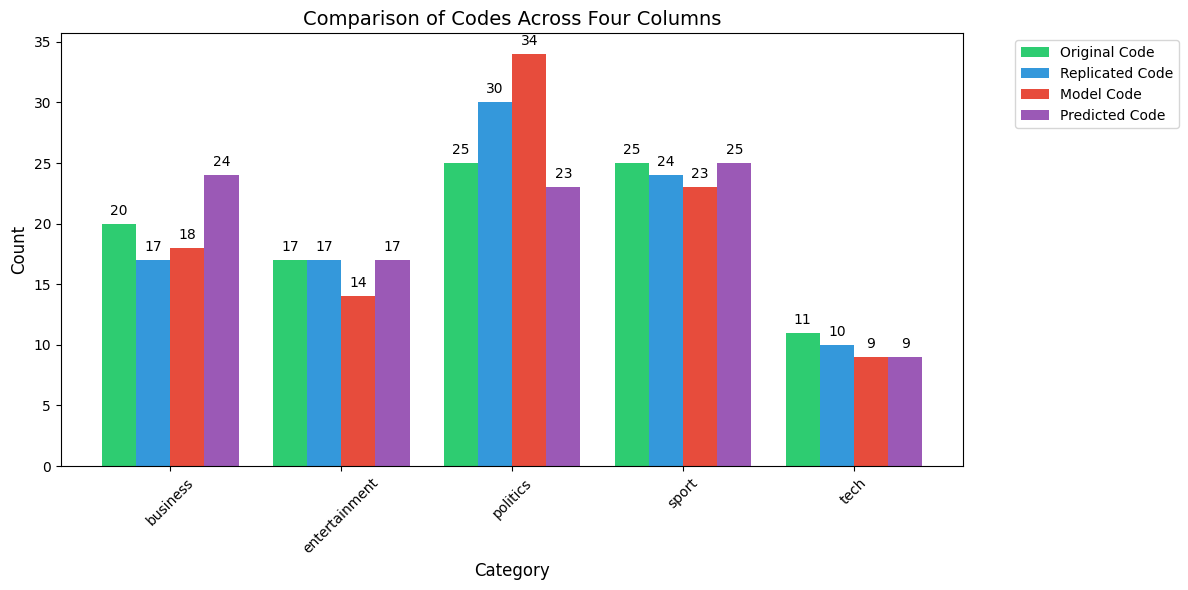

In [26]:
# Categories for the x-axis
categories = sorted(set(results['original_code']) | set(results['replicated_code']) | 
                   set(results['model_code']) | set(results['model_prediction']))

# Get value counts for each column, reindex to include all categories
original_code_counts = results['original_code'].value_counts().reindex(categories).fillna(0)
replicated_code_counts = results['replicated_code'].value_counts().reindex(categories).fillna(0)
model_code_counts = results['model_code'].value_counts().reindex(categories).fillna(0)
model_predictions_counts = results['model_prediction'].value_counts().reindex(categories).fillna(0)

# Number of categories
n = len(categories)

# Create a range for the x-axis based on the number of categories
x = np.arange(n)

# Set the width of the bars (adjusted for 4 bars)
width = 0.2  # Made smaller to accommodate 4 bars

# Create the plot
plt.figure(figsize=(12, 6))  # Made wider to accommodate 4 bars

# Create bars with adjusted positions
plt.bar(x - 1.5*width, original_code_counts, width, label='Original Code', color='#2ecc71')
plt.bar(x - 0.5*width, replicated_code_counts, width, label='Replicated Code', color='#3498db')
plt.bar(x + 0.5*width, model_code_counts, width, label='Model Code', color='#e74c3c')
plt.bar(x + 1.5*width, model_predictions_counts, width, label='Predicted Code', color='#9b59b6')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Comparison of Codes Across Four Columns', fontsize=14)
plt.xticks(x, categories, rotation=45)

# Add value labels on top of each bar
for i in range(n):
    plt.text(x[i] - 1.5*width, original_code_counts[i] + 0.5, str(int(original_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] - 0.5*width, replicated_code_counts[i] + 0.5, str(int(replicated_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] + 0.5*width, model_code_counts[i] + 0.5, str(int(model_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] + 1.5*width, model_predictions_counts[i] + 0.5, str(int(model_predictions_counts[i])), 
             ha='center', va='bottom')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
def calculate_similarity_metrics(results_df, ground_truth_col, prediction_col):
    """
    Calculate various similarity metrics between two columns
    """
    # Remove rows where either column has missing values
    valid_rows = results_df[[ground_truth_col, prediction_col]].dropna()
    
    if len(valid_rows) == 0:
        return {
            'accuracy': 0,
            'kappa': 0,
            'matching_cases': 0,
            'total_cases': 0,
            'percentage_match': 0
        }
    
    # Calculate metrics
    accuracy = accuracy_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    kappa = cohen_kappa_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    matching_cases = (valid_rows[ground_truth_col] == valid_rows[prediction_col]).sum()
    total_cases = len(valid_rows)
    percentage_match = (matching_cases / total_cases) * 100
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'matching_cases': matching_cases,
        'total_cases': total_cases,
        'percentage_match': percentage_match
    }

def analyze_code_similarities(results_df):
    """
    Analyze similarities between model outputs and human categorizations
    """
    # Comparisons to make
    comparisons = [
        ('original_code', 'model_code'),
        ('original_code', 'model_prediction'),
        ('replicated_code', 'model_code'),
        ('replicated_code', 'model_prediction')
    ]
    
    # Calculate metrics for each comparison
    results_dict = {}
    for truth_col, pred_col in comparisons:
        results_dict[f"{truth_col}_vs_{pred_col}"] = calculate_similarity_metrics(
            results_df, truth_col, pred_col
        )
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        'Comparison': [k.replace('_', ' ').title() for k in results_dict.keys()],
        'Accuracy': [v['accuracy'] for v in results_dict.values()],
        'Kappa Score': [v['kappa'] for v in results_dict.values()],
        'Matching Cases': [v['matching_cases'] for v in results_dict.values()],
        'Total Cases': [v['total_cases'] for v in results_dict.values()],
        'Match Percentage': [v['percentage_match'] for v in results_dict.values()]
    })
    
    # Format the percentage column
    summary_df['Match Percentage'] = summary_df['Match Percentage'].round(2).astype(str) + '%'
    
    # Create detailed confusion matrices
    confusion_matrices = {}
    for truth_col, pred_col in comparisons:
        valid_rows = results_df[[truth_col, pred_col]].dropna()
        if len(valid_rows) > 0:
            matrix = confusion_matrix(
                valid_rows[truth_col], 
                valid_rows[pred_col],
                labels=sorted(results_df[truth_col].unique())
            )
            confusion_matrices[f"{truth_col}_vs_{pred_col}"] = matrix
    
    return summary_df, confusion_matrices

# Run the analysis with the results dataframe
summary_df, confusion_matrices = analyze_code_similarities(results)

# Display the summary
print("\nSimilarity Analysis Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))
print("\nDetailed Analysis:")
print("=" * 100)

# Determine which model is more similar to human coding
original_code_comparison = summary_df[summary_df['Comparison'].str.contains('Original Code')]
replicated_code_comparison = summary_df[summary_df['Comparison'].str.contains('Replicated Code')]

print("\nComparison with Original Code:")
better_for_original = original_code_comparison.iloc[original_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_original['Comparison']}")
print(f"Accuracy: {better_for_original['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_original['Kappa Score']:.3f}")

print("\nComparison with Replicated Code:")
better_for_replicated = replicated_code_comparison.iloc[replicated_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_replicated['Comparison']}")
print(f"Accuracy: {better_for_replicated['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_replicated['Kappa Score']:.3f}")

# Print confusion matrices with labels
for name, matrix in confusion_matrices.items():
    print(f"\nConfusion Matrix for {name}:")
    categories = sorted(results[name.split('_vs_')[0]].unique())
    print("\nCategories:", categories)
    print(matrix)


Similarity Analysis Summary:
                         Comparison  Accuracy  Kappa Score  Matching Cases  Total Cases Match Percentage
        Original Code Vs Model Code  0.877551     0.842823              86           98           87.76%
  Original Code Vs Model Prediction  0.948980     0.934979              93           98            94.9%
      Replicated Code Vs Model Code  0.816327     0.761557              80           98           81.63%
Replicated Code Vs Model Prediction  0.775510     0.713565              76           98           77.55%

Detailed Analysis:

Comparison with Original Code:
Better model: Original Code Vs Model Prediction
Accuracy: 94.90%
Kappa Score: 0.935

Comparison with Replicated Code:
Better model: Replicated Code Vs Model Code
Accuracy: 81.63%
Kappa Score: 0.762

Confusion Matrix for original_code_vs_model_code:

Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']
[[15  0  5  0  0]
 [ 2 14  1  0  0]
 [ 0  0 25  0  0]
 [ 0  0  2 23  0]


# Key Findings

## Overall Performance
1. **Model Prediction vs Original Code** performs best overall:
   - Highest accuracy (94.90%)
   - Highest Kappa score (0.935)
   - 93 out of 98 cases matched correctly
   
2. **Model Code vs Replicated Code** shows second-best performance:
   - Accuracy of 81.63%
   - Kappa score of 0.762
   - 80 out of 98 cases matched

## Comparison with Human Coders

### Against Original Code:
- Model Prediction performs significantly better (94.90%) than Model Code (87.76%)
- Both show very strong agreement (Kappa > 0.8)
- Model Prediction misclassified only 5 cases out of 98
- Model Code misclassified 12 cases out of 98

### Against Replicated Code:
- Model Code performs slightly better (81.63%) than Model Prediction (78.57%)
- Both show substantial agreement (Kappa > 0.7)
- More discrepancies overall compared to Original Code

## Confusion Matrix Analysis

### Model Prediction vs Original Code (Best Performance):
- Perfect classification for:
  - Business (20/20)
  - Entertainment (17/17)
  - Sport (25/25)
- Minor confusions in:
  - Politics (22/25 correct, 2 misclassified as business, 1 as tech)
  - Tech (9/11 correct, 2 misclassified as business)

### Model Code vs Original Code:
- Strong performance in:
  - Sport (23/25)
  - Politics (25/25)
  - Entertainment (14/17)
- Main confusions in:
  - Business (15/20 correct, 5 misclassified as politics)
  - Tech (9/11 correct, some confusion with business and politics)

### Model Performance Against Replicated Code:
- Both models show more disagreement with Replicated Code than Original Code
- Most consistent classification for:
  - Sport category (23-24/24 correct)
  - Entertainment (14-16/17 correct)
- Most confusion in:
  - Business and Politics categories
  - Tech category shows consistent misclassifications

## Thoughts
1. The Model Prediction approach should be preferred when aiming to match Original Code.
2. Both models struggle most with Business, Politics, and Tech categories.
3. Sport and Entertainment categories are most consistently classified across all approaches.
